In [1]:
# Check if running in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB :
    # If we are in colab we don't have access to our custom modules so we clone the repository
    %git clone https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor.git
    # Pull last data from git
    %cd clothes-extractor && git pull && cd ..
  
# Install required packages
%pip install segmentation-models-pytorch torchmetrics argparse_dataclass segmentation_models_pytorch

import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=dba3f60067adfc95c94be2b79dd0194933a69a5b4916013d39554c31bffac4d1
  Stored in directory: /root/.cache/pip/wheels/22/16/f1/5369d23a06852d5f083d23a1addf0904575f1296f71b412ac8
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=8b3f8534134e57bb03d48b370017c814e165302c23c2cbcd2392bb3310d0a908
  Stored in directory: /root/.cache/pip/wheels/1f/9b/f5/9ccf3

In [2]:
if '_dh' in dict(globals()):
  # Import code form our github
  from pathlib import Path

  current_folder = globals()['_dh'][0]
  # This is hard coded to be able to run the notebook using a remote kernel
  os.chdir("/notebooks/clothes-extractor")
  
# Project imports
from dataset.dataset import ClothesDataLoader, ClothesDataset
from config import Config
from models.unet import Unet
import models.model_store as model_store
from trainer.trainer import train_model

seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
# torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

cuda


In [3]:
# Type here the path for the data set
dataset_path = os.path.join("data", "zalando-hd-resized")

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  %wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  %echo "Extracting the dataset. Please wait...."
  %unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  %rm path_check.tmp
  %rm zalando-hd-resized.zip
  print("Done")

Dataset already downloaded


In [4]:
cfg = Config()
cfg.load_height = 224
cfg.load_width = 224
cfg.workers = 1

In [67]:

test_dataset = ClothesDataset(cfg, "test", device=device)
train_dataset = ClothesDataset(cfg, "train", device=device)

test_dataloader = ClothesDataLoader(test_dataset, cfg.batch_size, num_workers=cfg.workers)
train_dataloader = ClothesDataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.workers)

def parse_image(output, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()
    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = output / 2 + 0.5
        output = np.transpose(output, (1, 2, 0))
    return output


def visualize_nn_output(output, image_index=0):
    plt.imshow(parse_image(output, image_index))
    plt.show()

def run_model_on_image(model, device, dataset, image_index):
    model.eval()
    image = dataset[image_index]
    image = image["centered_mask_body"].to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
    return output

In [15]:
model_store_unet_1 = model_store.ModelStore(model_name="unet_1")
model = smp.Unet(
        encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,  # model output channels (number of classes in your dataset)
        decoder_attention_type="scse"
    ).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model loaded: epoch=247 loss=0.6806664368900416 val_loss=1.3045345121814358
Image name: 00158_00.jpg


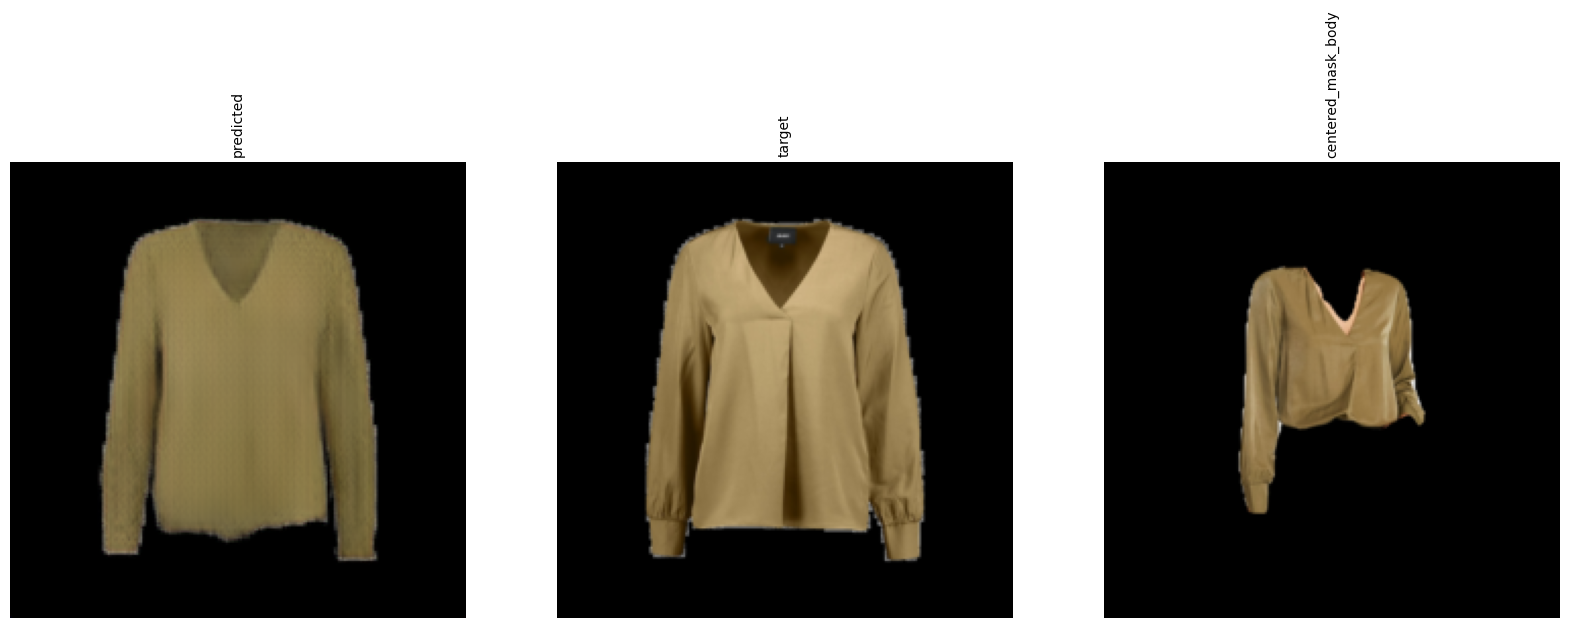

In [71]:

image_index = 25
chosen_dataset = test_dataset
model_path = "model_checkpoints/20240213_2159_e247_unet-resnet34-imagenet-scse.pt"

model, optimizer, epoch, loss, val_loss = model_store.load_model(
    model=model,
    optimizer=optimizer,
    path=model_path
)
print(f"Model loaded: epoch={epoch} loss={loss} val_loss={val_loss}")
print(f"Image name: {chosen_dataset[image_index]['img_name']}")

out = run_model_on_image(model, device, chosen_dataset, image_index)
# visualize_nn_output(out)

image = chosen_dataset[image_index]
image["predicted"] = parse_image(out)

# image_keys = ["img", "cloth", "cloth_mask", "predict", "agnostic_mask", "mask_body_parts", "mask_body", "centered_mask_body", "img_masked"]
image_keys = ["predicted", "target", "centered_mask_body"]
fig, axes = plt.subplots(1, len(image_keys), figsize=(20, 20))

for ax, key in zip(axes, image_keys):
    if key == "predicted":
        ax.imshow(image[key])
    else:
        image[key] = image[key] / 2 + 0.5 
        ax.imshow(image[key].cpu().permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(key, rotation=90, fontsize=10)